In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy as copy
import time
import matplotlib.pyplot as plt
import torch
from IPython.display import display

In [2]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll as fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

In [3]:
from ESbenchmark import ES, MLES

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
n_try = 8
n_deci = 50
eval_budget = 200
noise = 0.02
bounds = [(-2,2) for i in range(n_deci)]

In [6]:
aES = 0.05*np.ones(n_deci)

In [7]:
lr = 1e-3
epochs = 50
hidden_nodes = None

### Random NN dim compressor

In [8]:
layers = [
    torch.nn.Linear(n_deci,256),torch.nn.ELU(),
    torch.nn.Linear(   256,256),torch.nn.ELU(),
    torch.nn.Linear(   256,  2)
    ]

comp_scaler = 3
compressor = torch.nn.Sequential(*layers)

### Loss Funcs

In [9]:
def rastrigin(x,noise=noise):
    if x.ndim == 1:
        return np.sum(x**2 - np.cos(2*np.pi*x))/len(x)+1
    else:
        b,d = x.shape
        y = np.sum(x**2 - np.cos(2*np.pi*x),axis=1)/d +1
        if d==1:
            return float(y) + np.random.randn()*noise
        else:
            return y + np.random.randn(b)*noise


def rastrigin_torch(x,noise=noise):
    if x.dim() == 1:
        return torch.sum(x**2 - torch.cos(2*np.pi*x))/len(x) +1 +torch.randn(1)*noise
    else:
        b,d = x.shape
        return torch.sum(x**2 - torch.cos(2*np.pi*x),axis=1)/d +1 +torch.randn(b)*noise
    
def rastrigin_grad(x,noise=noise):
    x = torch.tensor(x.astype(np.float32), requires_grad=True)
    y = rastrigin_torch(x)
    y.backward()
    return x.grad.detach().numpy()

In [10]:
def loss_func(x):
    return rastrigin(comp_scaler*compressor(torch.tensor(x.reshape(-1,n_deci)).to(torch.float32)).detach().numpy())

def loss_func_torch(x):
    return rastrigin_torch(comp_scaler*compressor(x))

def loss_func_grad(x):
    x = torch.tensor(x.astype(np.float32), requires_grad=True)
    y = loss_func_torch(x)
    y.backward()
    return x.grad.detach().numpy()

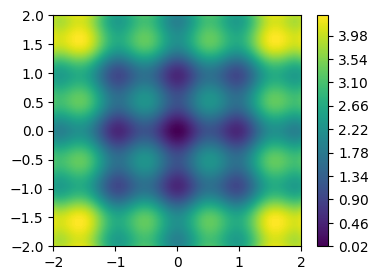

In [11]:
grid = np.linspace(-2,2,64)
x1,x2 = np.meshgrid(grid,grid)
xgrid = np.vstack((x1.flatten(), x2.flatten())).T
ygrid = rastrigin(xgrid,noise=0)

fig,ax = plt.subplots(figsize=(4,3))
cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=512)
fig.colorbar(cs,ax=ax)

# initial decision point

In [12]:
y=0
while(np.mean(y)<1.9):
    x_deci = np.clip(
                    np.float32( np.random.rand(1,n_deci)*4-2  
                                +noise*aES*np.random.randn(n_try,n_deci)   # add noise
                              ),
                    a_min=-2,a_max=2
                    )
    y = np.mean(loss_func(x_deci))

### Benchmark

In [13]:
class dictClass(dict):
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError as e:
            raise AttributeError(name) from e

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        if self.keys():
            m = max(map(len, list(self.keys()))) + 1
            return '\n'.join([k.rjust(m) + ': ' + repr(v)
                              for k, v in sorted(self.items())])
        else:
            return self.__class__.__name__ + "()"

    def __dir__(self):
        return list(self.keys())

In [14]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    dict_of_lists = {}
    
    for dictionary in list_of_dicts:
        for key, value in dictionary.items():
            if key in dict_of_lists:
                dict_of_lists[key].append(value)
            else:
                dict_of_lists[key] = [value]
    
    return dict_of_lists

### Define runs

In [15]:
def run(
        x0, 
        kES = None,
        auto_kES = False,
        lambda_grad = 0.1,
        lambda_ES = 1.0,
        auto_lambda_grad = False,
        n_grad_data_min = None,
        n_grad_data_max = None,
        n_grad_ave = None,
        adam = False,
        use_true_grad = False,
        use_gp_grad = False,
        max_y_err = None,
        use_NN_grad = True,
        lr = lr,
        epochs = epochs,
        hidden_nodes = hidden_nodes,
        fresh_train = True,
        ):
    
    es = MLES(
                 loss_func = loss_func,
                 x0 = x0,
                 aES = 0.05*np.ones(n_deci),
                 x_bounds = bounds,
                 kES = kES,
                 auto_kES = auto_kES,

                 lambda_grad = lambda_grad,
                 lambda_ES = lambda_ES,
                 auto_lambda_grad = auto_lambda_grad,
                 n_grad_data_min = n_grad_data_min,
                 n_grad_data_max = n_grad_data_max,
                 n_grad_ave = n_grad_ave,
                 adam = adam,

                 loss_func_grad = loss_func_grad,
                 use_true_grad = use_true_grad,

                 use_gp_grad = use_gp_grad,
                 max_y_err = max_y_err,

                 use_NN_grad = use_NN_grad,
                 lr = lr,
                 epochs = epochs,
                 hidden_nodes = hidden_nodes,
                 fresh_train = fresh_train
            )
    
    es(eval_budget)
    
    return es

In [16]:
def run_benchmark(
        kES,
        auto_kES,
        lambda_grad,
        lambda_ES,
        auto_lambda_grad,
        n_grad_data_min,
        n_grad_data_max,
        n_grad_ave,
        adam,
        use_true_grad,
        use_gp_grad,
        max_y_err,
        use_NN_grad,
        lr,
        epochs,
        hidden_nodes,
        fresh_train,
        n_try = n_try,
    ):
    
    benchmark = {
        'kES':kES,
        'auto_kES':auto_kES,
        'lambda_grad':lambda_grad,
        'lambda_ES':lambda_ES,
        'auto_lambda_grad':auto_lambda_grad,
        'n_grad_data_min':n_grad_data_min,
        'n_grad_data_max':n_grad_data_max,
        'n_grad_ave':n_grad_ave,
        'adam':adam,
        'use_true_grad':use_true_grad,
        'use_gp_grad':use_gp_grad,
        'max_y_err':max_y_err,
        'use_NN_grad':use_NN_grad,
        'lr':lr,
        'epochs':epochs,
        'hidden_nodes':hidden_nodes,
        'fresh_train':fresh_train}
#     display(pd.DataFrame(benchmark,index=[0]))    

    benchmark['x_history'] = []
    benchmark['y_history'] = []
    benchmark['xgrad_mse_history'] = []
    benchmark['timecost_history'] = []
    benchmark['MDD'] = []
    benchmark['meanDD'] = []


    for itry in range(n_try):
        es = run(x0=x_deci[itry,:],
                 kES = kES,
                 lambda_grad = lambda_grad,
                 lambda_ES = lambda_ES,
                 auto_lambda_grad = auto_lambda_grad,
                 n_grad_data_min = n_grad_data_min,
                 n_grad_data_max = n_grad_data_max,
                 n_grad_ave = n_grad_ave,
                 adam = adam,
                 use_true_grad = use_true_grad,
                 use_gp_grad = use_gp_grad,
                 use_NN_grad = use_NN_grad,
                 max_y_err = max_y_err,
                 lr = lr,
                 epochs = epochs,
                 hidden_nodes = hidden_nodes,
                 fresh_train=fresh_train,
                )
        x = np.array(es.history['x'])
        x = comp_scaler*compressor(torch.tensor(x.reshape(-1,n_deci)).to(torch.float32)).detach().numpy()

        benchmark['x_history'].append(x)
        benchmark['y_history'].append(es.history['y'])
        benchmark['timecost_history'].append(es.history['model']['time_cost'])
        y = es.history['y']
        cummin = pd.Series(y).cummin().to_numpy()
        MDD = np.max(y-cummin)
        meanDD = np.mean(y-cummin);
        grad_mse = []
        for grad_pred, grad_true in zip(es.history['model']['grad_pred'],es.history['model']['grad_true']):
            grad_mse.append( np.mean((grad_pred-grad_true[0][None,:])**2) );
            
        benchmark['xgrad_mse_history'].append(grad_mse)
        benchmark['MDD'].append(MDD)
        benchmark['meanDD'].append(meanDD)

    benchmark['x_history_mean']=np.mean(benchmark['x_history'],axis=0)
    benchmark['x_history_quantile']=np.array([np.quantile(benchmark['x_history'],0.1,axis=0),
                                              np.quantile(benchmark['x_history'],0.9,axis=0)])
    benchmark['y_history_mean']=np.mean(benchmark['y_history'],axis=0)
    benchmark['y_history_quantile']=np.array([np.quantile(benchmark['y_history'],0.1,axis=0),
                                              np.quantile(benchmark['y_history'],0.9,axis=0)])

    
    benchmark['MDD_mean'] = np.mean(benchmark['MDD']);
    benchmark['MDD_quantile'] = np.array([np.quantile(benchmark['MDD'],0.1,axis=0),
                                          np.quantile(benchmark['MDD'],0.9,axis=0)])
    
    benchmark['meanDD_mean'] = np.mean(benchmark['meanDD']);
    benchmark['meanDD_quantile'] = np.array([np.quantile(benchmark['meanDD'],0.1,axis=0),
                                             np.quantile(benchmark['meanDD'],0.9,axis=0)])
    
    benchmark['xgrad_mse_history_mean'] = np.mean(benchmark['xgrad_mse_history'],axis=0);
    benchmark['xgrad_mse_history_quantile'] = np.array([np.quantile(benchmark['xgrad_mse_history'],0.1,axis=0),
                                                        np.quantile(benchmark['xgrad_mse_history'],0.9,axis=0)])
    
    benchmark['xgrad_mse_mean'] = np.mean(benchmark['xgrad_mse_history']);
    try:
        benchmark['xgrad_mse_quantile'] = np.array([np.quantile(benchmark['xgrad_mse_history'],0.1),
                                                    np.quantile(benchmark['xgrad_mse_history'],0.9)])
    except:
        pass

    benchmark['timecost_history_mean'] = np.mean(benchmark['timecost_history'],axis=0);
    try:    
        benchmark['timecost_history_quantile'] = np.array([np.quantile(benchmark['timecost_history'],0.1,axis=0),
                                                           np.quantile(benchmark['timecost_history'],0.9,axis=0)])
    except:
        pass
    
    benchmark['timecost_mean'] = np.mean(benchmark['timecost_history']);
    try:    
        benchmark['timecost_quantile'] = np.array([np.quantile(benchmark['timecost_history'],0.1),
                                                   np.quantile(benchmark['timecost_history'],0.9)])
    except:
        pass
    
    return benchmark

# run

In [17]:
benchmark_total = []

### benchmark references

In [18]:
kES = None
auto_kES = False
lambda_grad = 0
lambda_ES = 1.
auto_lambda_grad = False
n_grad_data_min = 50
n_grad_data_max = 100
n_grad_ave = 16
adam = False
use_true_grad = False
use_gp_grad = False
max_y_err = 0.01
use_NN_grad = False
lr = 1e-3
epochs = 100
hidden_nodes = None
fresh_train = True


benchmark_ref = []

for auto_kES in [True, False]:
    result = run_benchmark(kES,auto_kES,lambda_grad,lambda_ES,auto_lambda_grad,
                           n_grad_data_min,n_grad_data_max,n_grad_ave,adam,
                           use_true_grad,use_gp_grad,max_y_err,use_NN_grad,
                           lr,epochs,hidden_nodes,fresh_train)
    benchmark_ref.append(result)
        
benchmark_total += benchmark_ref
benchmark_ref_dict = list_of_dicts_to_dict_of_lists(benchmark_ref)

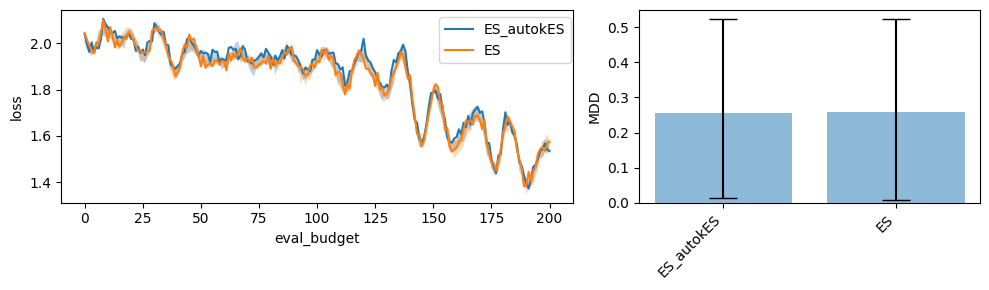

In [19]:
xaxis = np.arange(eval_budget+1)
fig,ax = plt.subplots(1,2,figsize=(10,3),gridspec_kw={'width_ratios':[1.5, 1]})

n = len(benchmark_ref)
labels = []

for B in benchmark_ref:
    label = 'ES'
    if B['auto_kES']:
        label += '_autokES'
    B['label'] = label
    ax[0].fill_between(xaxis, B['y_history_quantile'][0], 
                              B['y_history_quantile'][1], alpha=0.3) 
    ax[0].plot(B['y_history'][0], label=label)
    labels.append(label)
    
ax[0].legend(bbox_to_anchor=(1.01, 1))
ax[0].set_xlabel("eval_budget")
ax[0].set_ylabel("loss")

ax[1].bar(np.arange(n), benchmark_ref_dict['MDD_mean'],  
          yerr = np.array(benchmark_ref_dict['MDD_quantile']).T,
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1].set_ylabel('MDD')
ax[1].set_xticks(np.arange(n))
ax[1].set_xticklabels(labels, rotation = 45, ha="right")

fig.tight_layout()
# plt.savefig('[benchmark][noGrad]autokES.png',dpi=180)

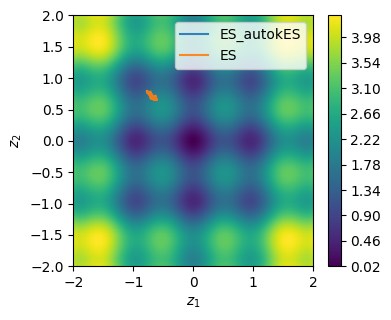

In [20]:
xaxis = np.arange(eval_budget+1)
fig,ax = plt.subplots(figsize=(4,3.3))

cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=512)
fig.colorbar(cs,ax=ax)
for B in benchmark_ref:
    for i in range(1,n_try):
        ax.plot(B['x_history'][i][:,0],B['x_history'][i][:,1],color='C'+str(i),lw=0.2,alpha=0.3)
for B in benchmark_ref:
    ax.plot(B['x_history'][0][:,0],B['x_history'][0][:,1], label=B['label'],alpha=0.9)

ax.legend()
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
# ax.set_xlim(-0.6, 0.5)
# ax.set_ylim( -0.2, 1.3)

fig.tight_layout()
# plt.savefig('[latent_dim][noGrad]autokES.png',dpi=180)

### does Adam really work if true gradient used?

In [21]:
kES = None
auto_kES = False
lambda_grad = 0.01
lambda_ES = 1.
auto_lambda_grad = False
n_grad_data_min = 50
n_grad_data_max = 100
n_grad_ave = 16
adam = False
use_true_grad = True
use_gp_grad = False
max_y_err = 0.01
use_NN_grad = False
lr = 1e-3
epochs = 100
hidden_nodes = None
fresh_train = True


benchmark_adam = []

for adam in [True, False]:
    for lambda_ES in [0, 1]:
        result = run_benchmark(kES,auto_kES,lambda_grad,lambda_ES,auto_lambda_grad,
                               n_grad_data_min,n_grad_data_max,n_grad_ave,adam,
                               use_true_grad,use_gp_grad,max_y_err,use_NN_grad,
                               lr,epochs,hidden_nodes,fresh_train)
        benchmark_adam.append(result)
        
benchmark_total += benchmark_adam
benchmark_adam_dict = list_of_dicts_to_dict_of_lists(benchmark_adam)

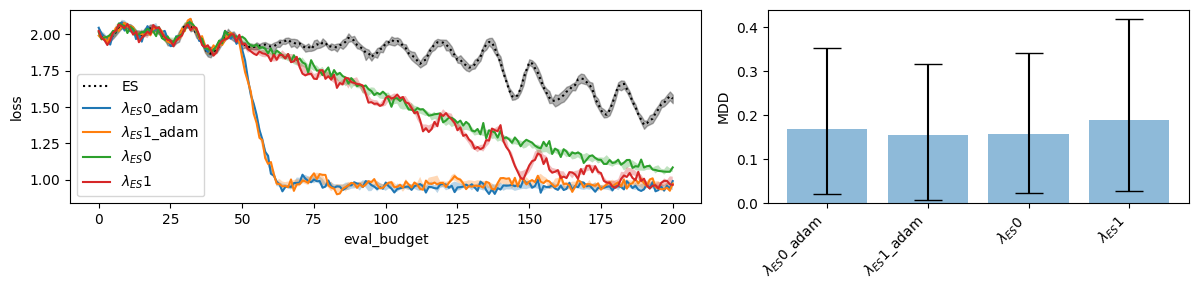

In [22]:
xaxis = np.arange(eval_budget+1)
fig,ax = plt.subplots(1,2,figsize=(12,3),gridspec_kw={'width_ratios':[1.5, 1]})

n = len(benchmark_adam)
labels = []

ax[0].plot(xaxis, benchmark_ref[1]['y_history_mean'],label=benchmark_ref[1]['label'],color='k',ls=':') 
ax[0].fill_between(xaxis, benchmark_ref[1]['y_history_quantile'][0], 
                          benchmark_ref[1]['y_history_quantile'][1], color='k',alpha=0.3) 
for B in benchmark_adam:
    label = '$\lambda_{ES}$' + str(B['lambda_ES'])
    if B['adam']:
        label += '_adam'
    B['label'] = label      
    ax[0].fill_between(xaxis, B['y_history_quantile'][0], 
                                B['y_history_quantile'][1], alpha=0.3) 
#     ax[0].plot(B['y_history_mean'],label=label) 
    ax[0].plot(B['y_history'][0],label=label) 
    
    labels.append(label)
ax[0].legend()
ax[0].set_xlabel("eval_budget")
ax[0].set_ylabel("loss")

ax[1].bar(np.arange(n), benchmark_adam_dict['MDD_mean'],  yerr = np.array(benchmark_adam_dict['MDD_quantile']).T,
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1].set_ylabel('MDD')
ax[1].set_xticks(np.arange(n))
ax[1].set_xticklabels(labels, rotation = 45, ha="right")

fig.tight_layout()
# plt.savefig('[benchmark][trueGrad]adam.png',dpi=180)

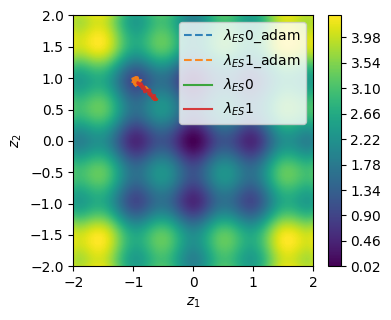

In [23]:
xaxis = np.arange(eval_budget+1)
fig,ax = plt.subplots(figsize=(4,3.3))

cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=512)
fig.colorbar(cs,ax=ax)
for B in benchmark_adam:
    for i in range(1,n_try):
        ax.plot(B['x_history'][i][:,0],B['x_history'][i][:,1],color='C'+str(i),lw=0.2,alpha=0.3)
for B in benchmark_adam:
    if B['adam']:
        ls = '--'
    else:
        ls = '-'
    ax.plot(B['x_history'][0][:,0],B['x_history'][0][:,1], label=B['label'],alpha=0.9,ls=ls)
    

ax.legend()
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
# ax.set_xlim(-0.6, 0.5)
# ax.set_ylim( -0.2, 1.3)

fig.tight_layout()
# plt.savefig('[latent_dim][trueGrad]adam.png',dpi=180)

### NN vs GP

In [24]:
kES = None
auto_kES = False
lambda_grad = 0.01
lambda_ES = 1.
auto_lambda_grad = False
n_grad_data_min = 50
n_grad_data_max = 100
n_grad_ave = 16
adam = False
use_true_grad = False
use_gp_grad = False
max_y_err = 0.02
use_NN_grad = False
lr = 1e-3
epochs = 20
hidden_nodes = [2048,256,1024,64,512]
fresh_train = False


benchmark_NN_GP = []

for use_gp_grad, use_NN_grad in [ [True, False], [False,True] ]:
    for lambda_ES in [0, 1]:
        for adam in [True, False]:
            result = run_benchmark(kES,auto_kES,lambda_grad,lambda_ES,auto_lambda_grad,
                                   n_grad_data_min,n_grad_data_max,n_grad_ave,adam,
                                   use_true_grad,use_gp_grad,max_y_err,use_NN_grad,
                                   lr,epochs,hidden_nodes,fresh_train)
            benchmark_NN_GP.append(result)
        
benchmark_total += benchmark_NN_GP
benchmark_NN_GP_dict = list_of_dicts_to_dict_of_lists(benchmark_NN_GP)

In [25]:
len(benchmark_NN_GP)

8

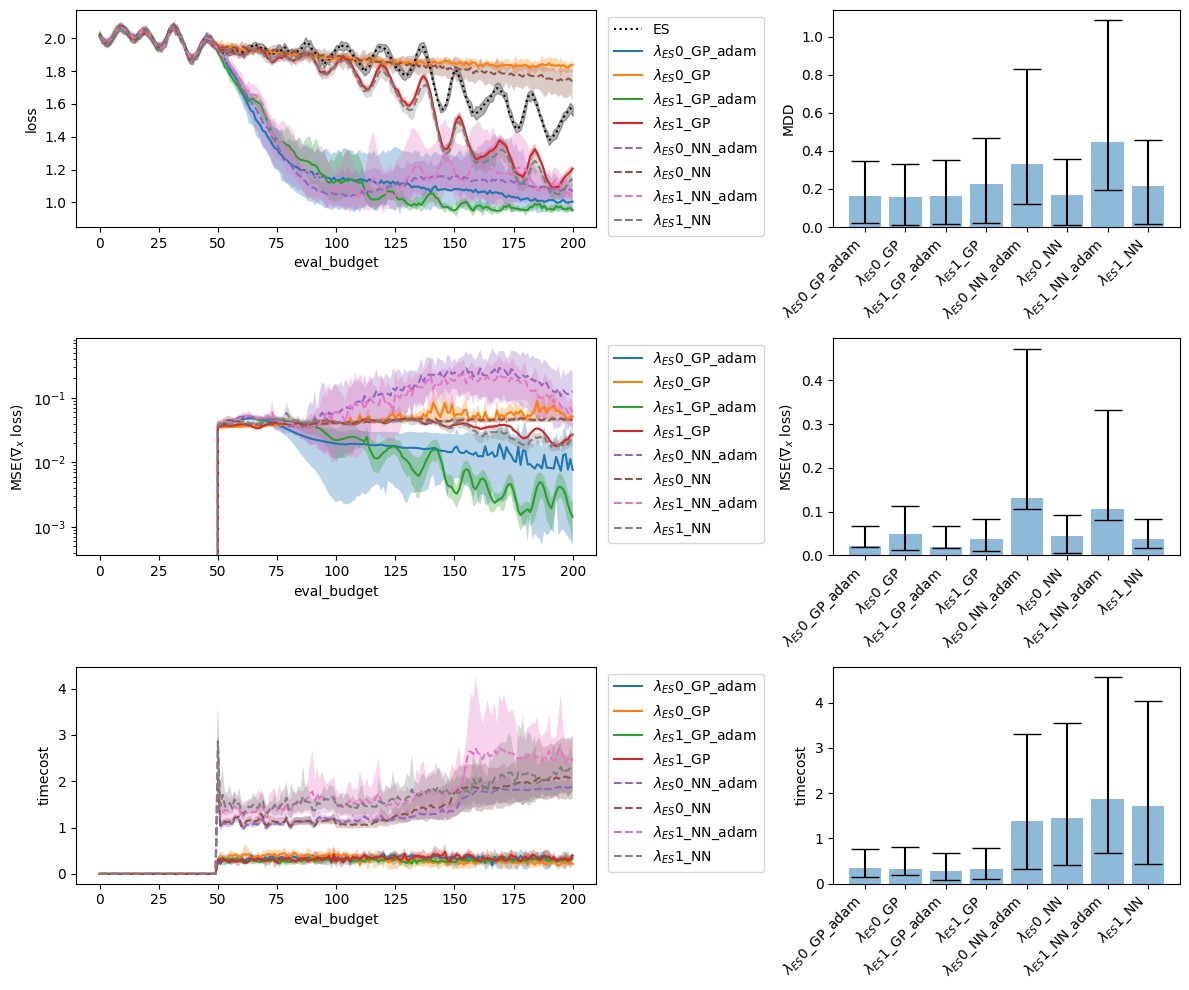

In [26]:
xaxis = np.arange(eval_budget+1)
fig,ax = plt.subplots(3,2,figsize=(12,10),gridspec_kw={'width_ratios':[1.5, 1]})

n = len(benchmark_NN_GP)
labels = []

ax[0,0].plot(xaxis, benchmark_ref[1]['y_history_mean'],label=benchmark_ref[1]['label'],color='k',ls=':') 
ax[0,0].fill_between(xaxis, benchmark_ref[1]['y_history_quantile'][0], 
                            benchmark_ref[1]['y_history_quantile'][1], color='k',alpha=0.3) 
for B in benchmark_NN_GP:
    label = '$\lambda_{ES}$' + str(B['lambda_ES'])
    if B['use_NN_grad']:
        label += '_NN'
        ls = '--'
    else:
        label += '_GP'
        ls = '-'
    if B['adam']:
        label += '_adam'
    B['label'] = label        
    ax[0,0].plot(B['y_history_mean'],label=label,ls=ls) 
    ax[0,0].fill_between(xaxis, B['y_history_quantile'][0], 
                                B['y_history_quantile'][1], alpha=0.3) 
    
    labels.append(label)
ax[0,0].legend(bbox_to_anchor=(1.01, 1))
ax[0,0].set_xlabel("eval_budget")
ax[0,0].set_ylabel("loss")

ax[0,1].bar(np.arange(n), benchmark_NN_GP_dict['MDD_mean'],  yerr = np.array(benchmark_NN_GP_dict['MDD_quantile']).T,
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[0,1].set_ylabel('MDD')
ax[0,1].set_xticks(np.arange(n))
ax[0,1].set_xticklabels(labels, rotation = 45, ha="right")



for i,B in enumerate(benchmark_NN_GP):
    if B['use_NN_grad']:
        ls = '--'
    else:
        ls = '-'
    mean = np.zeros(eval_budget+1)
    q90  = np.zeros(eval_budget+1)
    q10  = np.zeros(eval_budget+1)
    mean[-len(B['xgrad_mse_history_mean']):] = B['xgrad_mse_history_mean']
    q10 [-len(B['xgrad_mse_history_mean']):] = B['xgrad_mse_history_quantile'][0]
    q90 [-len(B['xgrad_mse_history_mean']):] = B['xgrad_mse_history_quantile'][1]
    ax[1,0].plot(xaxis,mean,label=labels[i],ls=ls) 
    ax[1,0].fill_between(xaxis,q10,q90, alpha=0.3) 
ax[1,0].legend(bbox_to_anchor=(1.01, 1))
ax[1,0].set_xlabel("eval_budget")
ax[1,0].set_ylabel(r'MSE($\nabla_x$ loss)')
ax[1,0].set_yscale("log")


ax[1,1].bar(np.arange(n), benchmark_NN_GP_dict['xgrad_mse_mean'],  yerr = np.array(benchmark_NN_GP_dict['xgrad_mse_quantile']).T,
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[1,1].set_ylabel(r'MSE($\nabla_x$ loss)')
ax[1,1].set_xticks(np.arange(n))
ax[1,1].set_xticklabels(labels, rotation = 45, ha="right")


for i,B in enumerate(benchmark_NN_GP):
    if B['use_NN_grad']:
        ls = '--'
    else:
        ls = '-'
    mean = np.zeros(eval_budget+1)
    q90  = np.zeros(eval_budget+1)
    q10  = np.zeros(eval_budget+1)
    mean[-len(B['timecost_history_mean']):] = B['timecost_history_mean']
    q10 [-len(B['timecost_history_mean']):] = B['timecost_history_quantile'][0]
    q90 [-len(B['timecost_history_mean']):] = B['timecost_history_quantile'][1]
    ax[2,0].plot(xaxis,mean,label=labels[i],ls=ls) 
    ax[2,0].fill_between(xaxis,q10,q90, alpha=0.3) 
ax[2,0].legend(bbox_to_anchor=(1.01, 1))
ax[2,0].set_xlabel("eval_budget")
ax[2,0].set_ylabel("timecost")
# ax[2,0].set_yscale("log")


ax[2,1].bar(np.arange(n), benchmark_NN_GP_dict['timecost_mean'],  yerr = np.array(benchmark_NN_GP_dict['timecost_quantile']).T,
          align='center', alpha=0.5, ecolor='black', capsize=10)
ax[2,1].set_ylabel('timecost')
ax[2,1].set_xticks(np.arange(n))
ax[2,1].set_xticklabels(labels, rotation = 45, ha="right")

fig.tight_layout()
# fig.savefig('[benchmark][predGrad]GPvsNN_lambdaES_adam.png',dpi=180)

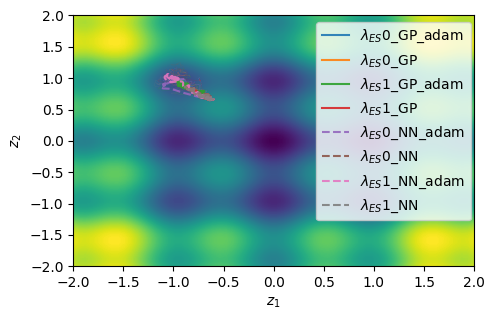

In [27]:
xaxis = np.arange(eval_budget+1)
fig,ax = plt.subplots(figsize=(5.05,3.3))

cs = ax.tricontourf(xgrid[:,0],xgrid[:,1],ygrid,levels=512)
# fig.colorbar(cs,ax=ax)
for B in benchmark_NN_GP:
    for i in range(1,n_try):
        ax.plot(B['x_history'][i][:,0],B['x_history'][i][:,1],color='C'+str(i),lw=0.2,alpha=0.3)
for B in benchmark_NN_GP:
    if B['use_NN_grad']:
        ls = '--'
    else:
        ls = '-'
    ax.plot(B['x_history'][0][:,0],B['x_history'][0][:,1], label=B['label'],alpha=0.9,ls=ls)
    

ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
# ax.set_xlim(-0.6, 0.5)
# ax.set_ylim( -0.2, 1.3)

fig.tight_layout()
# plt.savefig('[latent_dim][predGrad]GPvsNN_lambdaES_adam.png',dpi=180)

In [28]:
import pickle
# pickle.dump(benchmark_total,open('gradES_benchmark_100D_2Drastrigin_3days.pickle','wb'))